1. torchvision을 사용하여 CIFAR10의 학습용 데이터, 시험용 데이터 불러오기, 정규화
2. 합성곱 신경망 정의
3. 손실 함수 정의
4. 학습용 데이터를 사용하여 신경망 학습
5. 시험용 데이터를 사용하여 신경망 검사

In [1]:
#결과 inline에 출력
%matplotlib inline

In [2]:
import torch
import torchvision
from torchvision.datasets import FashionMNIST
# from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import collections
from sklearn import datasets
from imblearn import under_sampling
from typing import Any, Callable, Dict, List, Optional, Tuple
import os
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
print(torch.cuda.device_count())

2


In [5]:
print(torch.__version__)

1.7.1+cu101


In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 2048

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers= 8 ,pin_memory= True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8, pin_memory= True)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [7]:
type(trainset.data)

torch.Tensor

In [8]:
type(trainset.targets)

torch.Tensor

In [9]:
print('Original dataset shape %s' % collections.Counter(trainset.targets.tolist()))


Original dataset shape Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})


In [10]:
class unbalance_FashionMNIST(FashionMNIST):
     def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False,
    ) -> None:
        super(unbalance_FashionMNIST, self).__init__(root, transform=transform,
                                    target_transform=target_transform)
        
        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file
     
        self.data, self.targets = torch.load(os.path.join(self.processed_folder, data_file))
        rus = under_sampling.RandomUnderSampler(
            sampling_strategy={
                0: 600,
                1: 6000,
                2: 600,
                3: 6000,
                4: 600,
                5: 6000,
                6: 600,
                7: 6000,
                8: 600,
                9: 6000
                
            },
            random_state=42
        )
        self.data, self.targets = rus.fit_resample(np.array(self.data).reshape(60000,28*28), np.array(self.targets))
        self.data, self.targets = torch.Tensor(self.data.reshape(-1,28,28)).to(dtype=torch.uint8), torch.Tensor(self.targets).to(dtype=torch.uint8)



In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 2048

trainset = unbalance_FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers= 14 ,pin_memory= True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=14, pin_memory= True)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [12]:
print('reshape dataset shape %s' % collections.Counter(trainset.targets.tolist()))

reshape dataset shape Counter({1: 6000, 3: 6000, 5: 6000, 7: 6000, 9: 6000, 0: 600, 2: 600, 4: 600, 6: 600, 8: 600})


In [13]:
type(trainset.data)

torch.Tensor

In [14]:
type(trainset.targets)

torch.Tensor

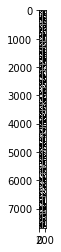

Pullover Sneaker Sneaker Trouser


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
print(dataiter)
images, labels = dataiter.next()
# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
          nn.Conv2d(1, 32, 3),
          nn.ReLU(),
          nn.Conv2d(32, 32, 3),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.2)
        )

        self.layer2 = torch.nn.Sequential(
          nn.Conv2d(32, 64, 3),
          nn.ReLU(),
          nn.Conv2d(64, 64, 3),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.2)
        )


        self.fc1 = nn.Linear(1024, 120)
        self.bn1 = nn.BatchNorm1d(120)
        self.bn2 = nn.BatchNorm1d(84)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x


net = Net()

if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)

net.to(device)

DataParallel(
  (module): Net(
    (layer1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.2, inplace=False)
    )
    (layer2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.2, inplace=False)
    )
    (fc1): Linear(in_features=1024, out_features=120, bias=True)
    (bn1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_feat

In [17]:
import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [18]:
def custom_FL(output,labels, alpha=0.25, gamma=2):
    count_output = len(labels)
    loss_total = 0.0
    for i in range(count_output):
        pt = torch.exp(output[i][labels[i]])/sum(torch.exp(output[i]))
        loss = -1*alpha*((1-pt)**gamma)*(torch.log(pt))
        loss_total += loss
    return loss_total/count_output

In [19]:
net.train()
for epoch in range(200):   # 데이터셋을 수차례 반복합니다.
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].to(device), data[1].to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = custom_FL(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 0.212
[2,    10] loss: 0.061
[3,    10] loss: 0.040
[4,    10] loss: 0.030
[5,    10] loss: 0.026
[6,    10] loss: 0.023
[7,    10] loss: 0.020
[8,    10] loss: 0.019
[9,    10] loss: 0.017
[10,    10] loss: 0.015
[11,    10] loss: 0.014
[12,    10] loss: 0.013
[13,    10] loss: 0.013
[14,    10] loss: 0.012
[15,    10] loss: 0.011
[16,    10] loss: 0.011
[17,    10] loss: 0.010
[18,    10] loss: 0.009
[19,    10] loss: 0.008
[20,    10] loss: 0.009
[21,    10] loss: 0.008
[22,    10] loss: 0.007
[23,    10] loss: 0.008
[24,    10] loss: 0.008
[25,    10] loss: 0.007
[26,    10] loss: 0.007
[27,    10] loss: 0.006
[28,    10] loss: 0.006
[29,    10] loss: 0.006
[30,    10] loss: 0.007
[31,    10] loss: 0.006
[32,    10] loss: 0.005
[33,    10] loss: 0.004
[34,    10] loss: 0.004
[35,    10] loss: 0.005
[36,    10] loss: 0.004
[37,    10] loss: 0.004
[38,    10] loss: 0.003
[39,    10] loss: 0.004
[40,    10] loss: 0.003
[41,    10] loss: 0.003
[42,    10] loss: 0.003
[

In [20]:
# PATH = './fashion_net.pth'
# torch.save(net.state_dict(), PATH)

In [21]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
# 이미지를 출력합니다.
# imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(64)))

GroundTruth:  Shirt  Coat Sneaker   Bag Sneaker  Coat Pullover Dress Shirt T-shirt/top Dress Dress T-shirt/top  Coat   Bag  Coat Sandal Ankle boot Sneaker T-shirt/top T-shirt/top  Coat Pullover Pullover Pullover   Bag Sneaker Ankle boot Ankle boot   Bag Pullover Ankle boot  Coat Shirt T-shirt/top  Coat Sneaker Dress Shirt Trouser Sneaker   Bag Trouser Pullover Pullover   Bag Shirt T-shirt/top Trouser Sneaker Pullover Dress Sandal Sandal Dress Pullover Sneaker Dress Dress Shirt Sandal Trouser Pullover  Coat


In [22]:
# net = Net()
# net.to(device)
# net.load_state_dict(torch.load(PATH))

In [23]:
net.train()
outputs = net(images)

In [24]:
print(outputs[1])

tensor([-5.3832, -0.8067,  0.0953, -2.7359,  5.8342, -2.6733, -0.0135, -2.2347,
        -3.6777, -2.0360], device='cuda:0', grad_fn=<SelectBackward>)


In [25]:
_, predicted = torch.max(outputs[0:2], 1)
print(predicted)

tensor([6, 4], device='cuda:0')


In [26]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

Predicted:  Shirt  Coat Sneaker Trouser Sneaker  Coat Dress Dress Shirt Dress Dress Dress T-shirt/top Dress   Bag  Coat Sandal Ankle boot Sneaker T-shirt/top T-shirt/top Dress Pullover Pullover Sandal   Bag Sneaker Ankle boot Sneaker   Bag Pullover Ankle boot Dress Shirt T-shirt/top Dress Ankle boot Dress Shirt Trouser Sneaker   Bag Trouser Dress  Coat   Bag Shirt T-shirt/top Trouser Sneaker Shirt Dress Sandal Sandal Dress  Coat Sneaker Dress Dress Shirt Sneaker Trouser Pullover  Coat Dress Ankle boot T-shirt/top Sneaker Sneaker  Coat  Coat Sneaker Dress T-shirt/top  Coat Trouser Dress Dress Sandal Pullover Ankle boot T-shirt/top Trouser   Bag Dress   Bag Pullover Shirt Dress Sandal Sneaker  Coat   Bag Sandal   Bag Trouser Sandal Ankle boot Sandal Sneaker Sneaker Trouser Sneaker  Coat Shirt T-shirt/top Trouser Pullover  Coat Sneaker Sandal Sandal Sandal   Bag Dress Sneaker Ankle boot Sneaker   Bag Dress Pullover Dress Dress Ankle boot Trouser Pullover Sneaker Pullover Sandal Trouser Sa

In [27]:
net.eval()
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 88 %


In [28]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class T-shirt/top is: 77.2 %
Accuracy for class Trouser is: 98.6 %
Accuracy for class Pullover is: 83.8 %
Accuracy for class Dress is: 98.6 %
Accuracy for class Coat  is: 75.3 %
Accuracy for class Sandal is: 99.5 %
Accuracy for class Shirt is: 67.0 %
Accuracy for class Sneaker is: 97.9 %
Accuracy for class Bag   is: 94.6 %
Accuracy for class Ankle boot is: 96.8 %


In [29]:
for i in range(10):
    print(classes[labels[i]])

Coat
Sandal
Bag
Dress
Ankle boot
Coat
Dress
Dress
Shirt
Coat
